In [1]:
import pandas as pd
import numpy as np
import os
import arch
import matplotlib.pyplot as plt
from baseModule.getStockData import get_stock_data
from baseModule.bayesFlexibleFourier import flexible_fourier_regression as FFR
from baseModule.dayVol import EWMA, GARCH

In [2]:
stock_RIC = "AAPL.O"

In [3]:
## Retrieve daily volatility and intraday volatility aggregated at 10min intervals
full_data, dayVol = get_stock_data(stock_RIC, aggre_min=10, start_time= "2021-08-01", end_time="2021-08-30")

In [4]:
full_data.head()

,TimeIndex,High,Low,Open,Close,Auction,Volume,Date,RIC,Vol,Vol_Day,Open_at_4:00,Close_at_4:00,High_at_4:00,Low_at_4:00,AuctionVol
0,2021-08-02 09:40:00,146.9500,145.54,146.3600,145.5800,145.52,5072724.0,2021-08-02,AAPL.O,0.005954,0.06825,145.65,145.52,145.76,145.37,0.001811
1,2021-08-02 09:50:00,145.8000,145.25,145.6100,145.6899,145.52,3214321.0,2021-08-02,AAPL.O,0.002651,0.06825,145.65,145.52,145.76,145.37,0.001811
2,2021-08-02 10:00:00,146.0108,145.34,145.6796,145.9500,145.52,2170725.0,2021-08-02,AAPL.O,0.003045,0.06825,145.65,145.52,145.76,145.37,0.001811
3,2021-08-02 10:10:00,146.1550,145.60,145.9300,145.7933,145.52,2198550.0,2021-08-02,AAPL.O,0.002626,0.06825,145.65,145.52,145.76,145.37,0.001811
4,2021-08-02 10:20:00,146.2400,145.79,145.7999,146.1399,145.52,1645806.0,2021-08-02,AAPL.O,0.001629,0.06825,145.65,145.52,145.76,145.37,0.001811


In [5]:
dayVol.head()

,Date,Vol
228,2021-08-02,0.068250
229,2021-08-03,0.066320
230,2021-08-04,0.058795
231,2021-08-05,0.044317
232,2021-08-06,0.049305


Text(0.5, 0, 'Intraday Interval Index')

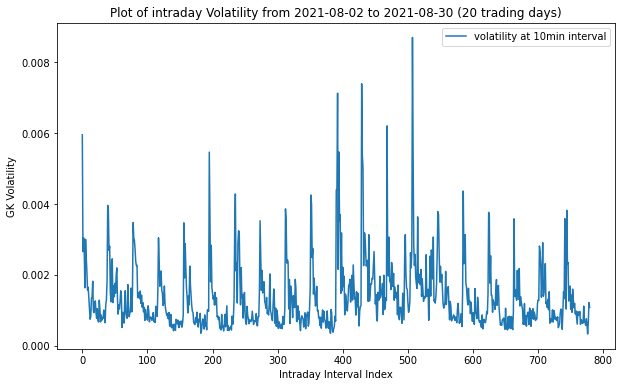

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(full_data["Vol"], label="volatility at 10min interval")
plt.legend()
plt.title("Plot of intraday Volatility from 2021-08-02 to 2021-08-30 (20 trading days)")
plt.ylabel("GK Volatility")
plt.xlabel("Intraday Interval Index")

In [7]:
## Use EWMA to smooth/process daily volatility and predict nextday dayVol Level
dayVol_model = EWMA(span=20)
dayVol["forecast"] = dayVol_model.fit(dayVol["Vol"])
dayVol_lvl = dayVol["forecast"].values[-1]
print("predicted daily volatility is: {:.3f}".format(dayVol_lvl))

predicted daily volatility is: 0.063


In [8]:
## Reshape the training window data into (39, 20) tensor
## Feed into flexible fourier for training
dayVol_train = dayVol["Vol"][-20:]
vol_train = full_data[-20*39:].Vol
vol_train = vol_train.values.reshape(39, 20)
fourier_model = FFR(N=39, di=[], J=2, P=17)
res = fourier_model.train(vol_train, dayVol_train, tol=1e-7)
print("Model fit success: {}".format(res.success))

Model fit success: True


Text(0.5, 0, 'Intraday Interval Index')

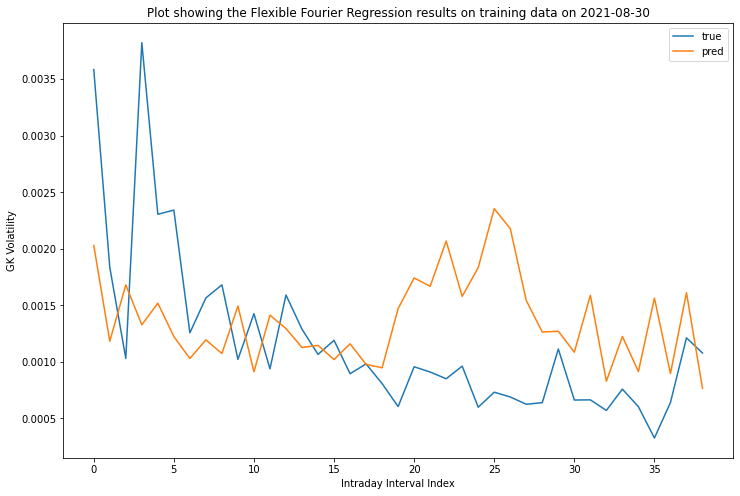

In [9]:
## Showing fitting results for last day of training data (2021-08-30)
vol_test, dayVol_test = get_stock_data(stock_RIC, aggre_min=10, start_time="2021-08-27", end_time="2021-08-30")
test_result = fourier_model.predict(dayVol_test.Vol)
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.plot(vol_test.Vol, label="true")
ax.plot(test_result, label="pred")
plt.legend()
plt.title("Plot showing the Flexible Fourier Regression results on training data on 2021-08-30")
plt.ylabel("GK Volatility")
plt.xlabel("Intraday Interval Index")

In [10]:
## Predicting next day results (2021-08-31)
## Adding adaptive dayVol learning with data from 2021-08-31 before 3:50pm
vol_true, dayVol_true = get_stock_data(stock_RIC, aggre_min=10, start_time="2021-08-30", end_time="2021-08-31")
bayes_dayVol = fourier_model.vol_update(vol_true.Vol.values[0:38], dayVol_lvl, tol=1e-7)
print("Updated dayVol is: {:.3f}".format(bayes_dayVol[0]))
print("Initial dayVol is: {:.3f}".format(dayVol_lvl))

Updated dayVol is: 0.059
Initial dayVol is: 0.063


Text(0.5, 0, 'Intraday Interval Index')

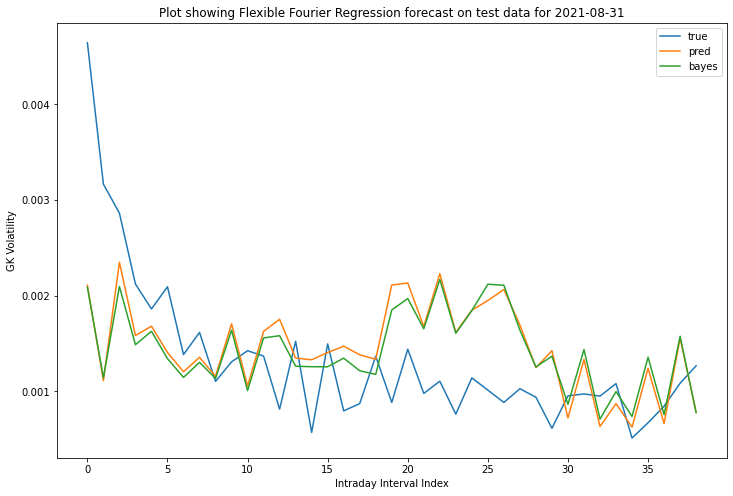

In [11]:
## Displaying the results
result = fourier_model.predict(dayVol_lvl)
bayes_result = fourier_model.predict(bayes_dayVol)

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.plot(vol_true.Vol, label="true")
ax.plot(result, label="pred")
ax.plot(bayes_result, label="bayes")
plt.legend()
plt.title("Plot showing Flexible Fourier Regression forecast on test data for 2021-08-31")
plt.ylabel("GK Volatility")
plt.xlabel("Intraday Interval Index")